### Atlas Data Analysis

Part 1

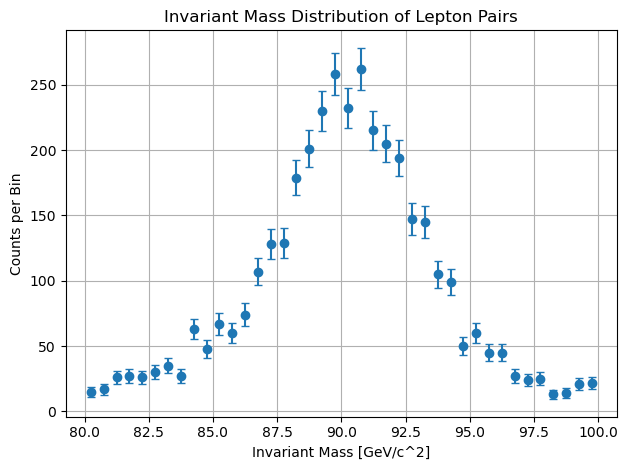

In [13]:
import numpy as np
import matplotlib.pyplot as plt


# Constants
m_z = 91.1880 # mass of z boson +- 0.0020 GeV/c^2
m_w = 80.3692 # mass of w boson +- 0.0133 Gev/c^2
m_h = 125.20 # mass of higgs boson  +- 0.11 Gev/c^2
m_e = 0.51099895000 # mass of electron +- 0.00000000015 Mev/c^2
m_mu = 105.6583755 # mass of a muon +- 0.0000023 MeV/c^2
m_tau = 1776.93 # mass of tau +- 0.09 MeV/c^2

#loading data
data = np.loadtxt('atlas_z_to_11.csv',delimiter=',', skiprows=1)
pT1, pT2 = data[:,0], data[:,1]
eta1, eta2 = data[:,2], data[:,3]
phi1, phi2 = data[:,4], data[:,5]
E1, E2 = data[:,6], data[:,7]

#natural units
px1 = pT1*np.cos(phi1)
px2 = pT2*np.cos(phi2)
py1 = pT1*np.sin(phi1)
py2 = pT2*np.sin(phi2)
pz1 = pT1*np.sinh(eta1)
pz2 = pT2*np.sinh(eta2)

#sum of components
E_tot = E1 + E2
px_tot = px1 + px2
py_tot = py1 + py2
pz_tot = pz1 + pz2

mass = np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

#plotting
bins = np.linspace(80,100,41)
counts, bin_edges = np.histogram(mass, bins=bins)
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
errors = np.sqrt(counts)

fig,ax = plt.subplots()
ax.errorbar(bin_centers, counts, yerr=errors, fmt='o', capsize=3)
ax.set_xlabel('Invariant Mass [GeV/c^2]')
ax.set_ylabel('Counts per Bin')
ax.set_title('Invariant Mass Distribution of Lepton Pairs')
ax.grid()
plt.tight_layout()

Part 2

<>:44: SyntaxWarning: invalid escape sequence '\c'
<>:44: SyntaxWarning: invalid escape sequence '\c'
/var/folders/k3/y6x_dc39173dg2tnbgbw7d3w0000gn/T/ipykernel_54515/2423492244.py:44: SyntaxWarning: invalid escape sequence '\c'
  f"$\chi^2_\\nu$ = {reduced_chi2:.1f}\n"


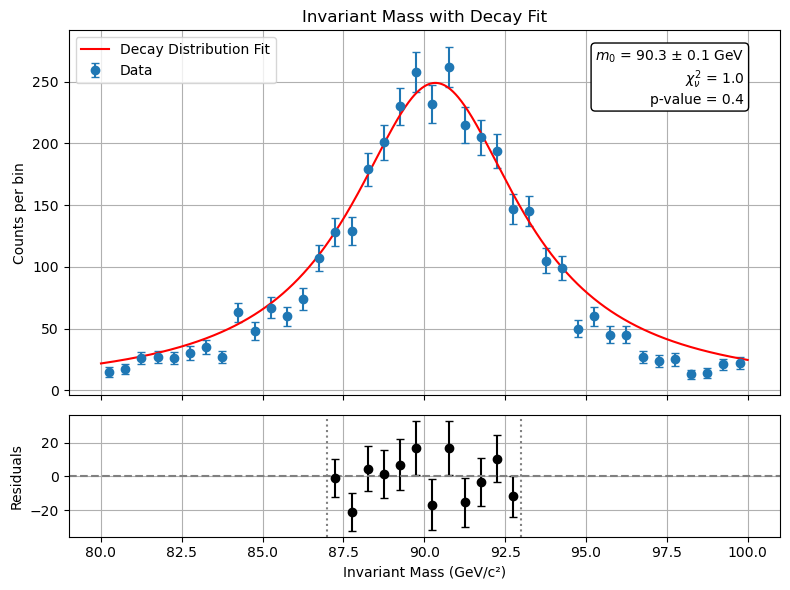

In [25]:
from scipy.optimize import curve_fit
from scipy.stats import chi2

#Decay distribution
def D(m,m0,gamma):
    return (1/np.pi)*((gamma/2) / ((m-m0)**2 + (gamma/2)**2))

#Fit 
def fit_func(m,m0,gamma):
    norm = 5000/2
    return norm * D(m,m0,gamma)

#fit range
fit_mask = (bin_centers > 87) & (bin_centers < 93)
x_fit = bin_centers[fit_mask]
y_fit = counts[fit_mask]
y_err = errors[fit_mask]

#fit model
params, covar = curve_fit(fit_func, x_fit, y_fit, sigma=y_err, absolute_sigma=True)
m0_fit, gamma_fit = params
m0_err = np.sqrt(covar[0,0])

y_model = fit_func(x_fit, *params)
residuals = y_fit - y_model
chi2_val = np.sum((residuals / y_err)**2)
dof = len(x_fit) - len(params)
reduced_chi2 = chi2_val / dof
p_value = 1 - chi2.cdf(chi2_val, dof)

#plot histogram w/ fit and residuals
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6), gridspec_kw={'height_ratios':[3,1]},sharex=True)

ax1.errorbar(bin_centers, counts, yerr=errors, fmt='o', capsize=3, label='Data')
m_plot = np.linspace(80,100,1000)
ax1.plot(m_plot, fit_func(m_plot, *params), color='red', label='Decay Distribution Fit')
ax1.set_ylabel('Counts per bin')
ax1.set_title('Invariant Mass with Decay Fit')
ax1.legend()
ax1.grid()

#annotation
annotation = (f"$m_0$ = {m0_fit:.1f} ± {m0_err:.1f} GeV\n"
              f"$\chi^2_\\nu$ = {reduced_chi2:.1f}\n"
              f"p-value = {p_value:.1f}")
ax1.annotate(annotation, xy=(0.95, 0.95), xycoords='axes fraction',
             ha='right', va='top', fontsize=10, bbox=dict(boxstyle="round", fc="w"))

#residuals
ax2.errorbar(x_fit, residuals, yerr=y_err, fmt='o', capsize=3, color='black')
ax2.axhline(0, color='gray', linestyle='--')
ax2.axvline(87, color='gray', linestyle=':')
ax2.axvline(93, color='gray', linestyle=':')
ax2.set_xlabel("Invariant Mass (GeV/c²)")
ax2.set_ylabel("Residuals")
ax2.grid()

plt.tight_layout()
plt.savefig('Figure 1.png')

Part 3

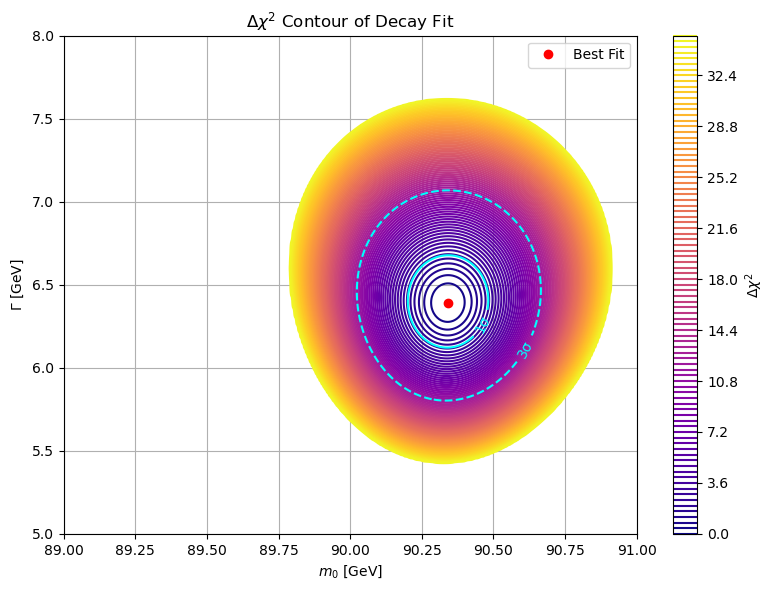

In [26]:
#2D chi^2 scan

m_vals = np.linspace(89,91,300)
g_vals = np.linspace(5,8,300)
M, G = np.meshgrid(m_vals, g_vals)
chi2_map = np.zeros_like(M)

for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        y_model_scan = fit_func(x_fit, M[i,j], G[i,j])
        chi2_val_scan = np.sum(((y_fit - y_model_scan)/y_err)**2)
        chi2_map[i,j] = chi2_val_scan

#delta chi^2 computation
#print(chi2_map)
chi2_min = np.min(chi2_map)
delta_chi2 = chi2_map - chi2_min
delta_chi2 = np.clip(delta_chi2,0,35)

#plot contour
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contour(M,G,delta_chi2,levels=100, cmap='plasma')
cbar = fig.colorbar(contour, ax=ax, label=r'$\Delta \chi^2$')

#confidence
levels = [2.30, 11.83]
contour_lines = ax.contour(M,G,delta_chi2, levels=levels, colors = ['cyan', 'cyan'], linestyles = ['solid','dashed'])
ax.clabel(contour_lines, fmt={2.30:'1σ', 11.83:'3σ'}, fontsize=10)

#best fit point
ax.plot(m0_fit, gamma_fit,'ro', label='Best Fit')
ax.set_xlabel(r'$m_0$ [GeV]')
ax.set_ylabel(r'$\Gamma$ [GeV]')
ax.set_title(r'$\Delta \chi^2$ Contour of Decay Fit')
ax.legend()
ax.grid()
plt.tight_layout()
plt.savefig('Figure 2')